In [7]:
from edgedroid import data as e_data

data, *bins = e_data.load_default_exec_time_data()
data

,run_id,ttf,exec_time,neuroticism
0,134146,0.597441,3.654797,0.375
1,134146,0.553513,4.438645,0.375
2,134146,0.561716,2.943222,0.375
3,134146,0.586512,5.405761,0.375
4,134146,0.558940,5.225161,0.375
...,...,...,...,...
6755,137353,0.557074,6.439071,0.625
6756,137353,0.534339,4.680858,0.625
6757,137353,0.560288,3.467878,0.625
6758,137353,0.579000,2.325759,0.625


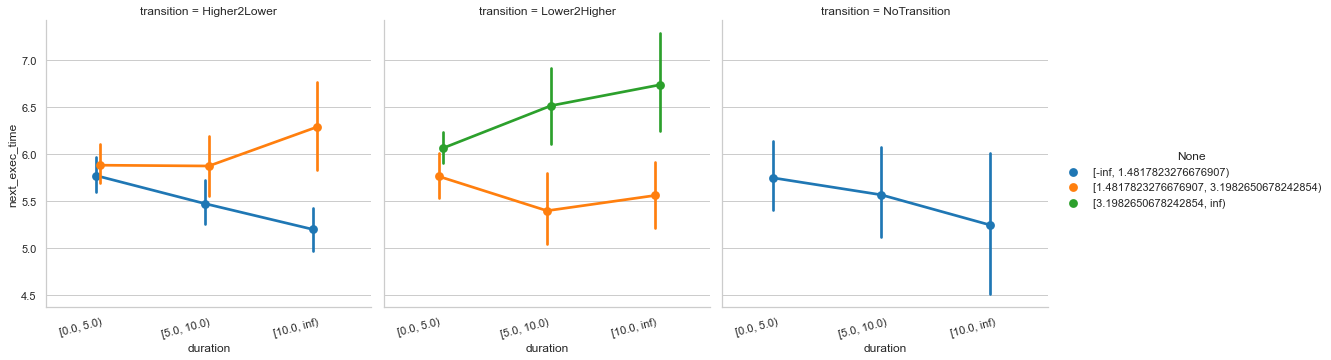

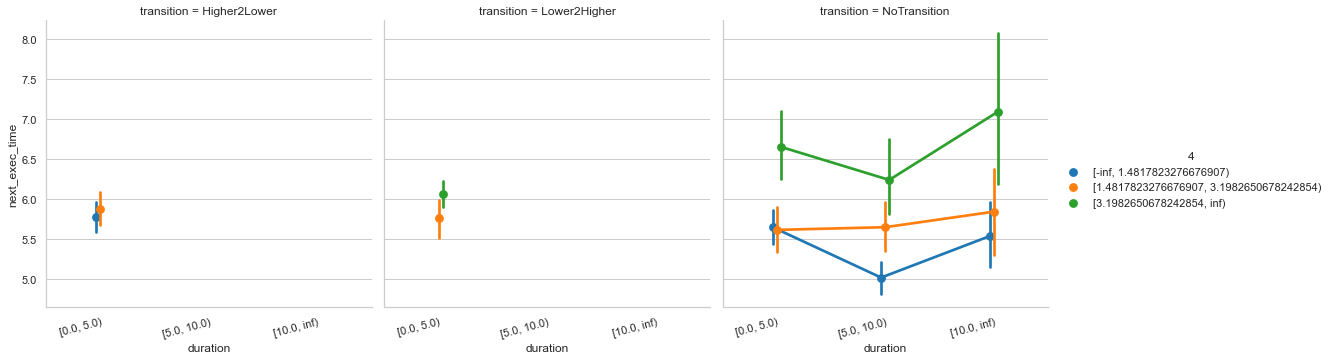

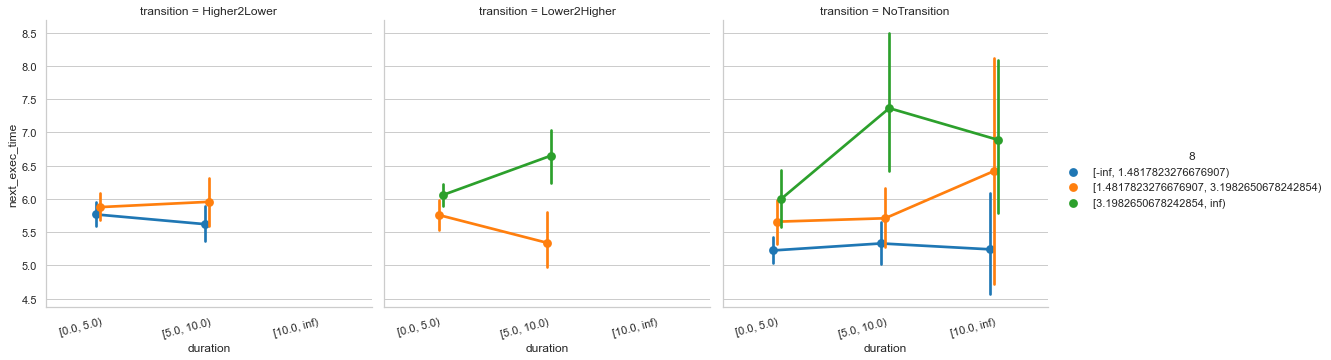

In [23]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook")
sns.set_style("whitegrid")

from edgedroid.models import preprocess_data

for fade_dist in (None, 4, 8):
    proc_data = preprocess_data(
        data,
        *bins,
        transition_fade_distance=fade_dist,
    )

    proc_data["trans_dur"] = proc_data[["transition", "duration"]].apply(tuple, axis=1)
    proc_data["imp_trans"] = proc_data[["impairment", "transition"]].apply(tuple, axis=1)

    fg = sns.catplot(
        kind="point",
        data=proc_data,
        x="duration",
        hue="impairment",
        y="next_exec_time",
        dodge=True,
        col="transition",
    )
    fg.legend.set_title(f"{fade_dist}")
    for ax in fg.axes.flat:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    plt.show()

In [90]:
import numpy as np
from collections import deque
from edgedroid.models.timings import ModelException, Transition
from typing import Optional
from pandas import arrays
import pandas as pd

proc_data, neuro_bins, impair_bins, duration_bins = e_data.load_default_exec_time_data()

ttfs = proc_data["ttf"].to_numpy()
ttfs = np.concatenate((ttfs, [-np.inf, np.inf]))

_, impair_bins = pd.qcut(proc_data["ttf"], 3, retbins=True)

impair_bins[0], impair_bins[-1] = -np.inf, np.inf

impair_bins = pd.arrays.IntervalArray.from_breaks(impair_bins, closed="left")

# impair_bins = pd.arrays.IntervalArray.from_breaks([-np.inf, 1, 3, 5, np.inf])

proc_data["neuroticism_raw"] = proc_data["neuroticism"]
proc_data["neuroticism"] = pd.cut(proc_data["neuroticism"], pd.IntervalIndex(neuro_bins))

processed_dfs = deque()
for run_id, df in proc_data.groupby("run_id"):
    # df = df.copy()
    df = df.copy()
    df["ttf"] = df["ttf"].shift().fillna(0)

    df["impairment"] = pd.cut(df["ttf"], pd.IntervalIndex(impair_bins))
    df = df.rename(columns={"exec_time": "next_exec_time"})

    # df["next_exec_time"] = df["exec_time"].shift(-1)
    df["prev_impairment"] = df["impairment"].shift()
    # df["transition"] = Transition.NONE.value

    # for each segment with the same impairment, count the number of steps
    # (starting from 1)
    diff_imp_groups = df.groupby(
        (df["impairment"].ne(df["prev_impairment"])).cumsum()
    )
    df["duration"] = diff_imp_groups.cumcount() + 1

    df["transition"] = None
    df.loc[df["prev_impairment"] < df["impairment"], "transition"] = Transition.L2H.value
    df.loc[df["prev_impairment"] > df["impairment"], "transition"] = Transition.H2L.value

    df["transition"] = df["transition"].fillna(method="ffill")

    processed_dfs.append(df)

proc_data = pd.concat(processed_dfs, ignore_index=False)

# coerce some types for proper functionality
proc_data["transition"] = proc_data["transition"].astype("category")
proc_data["neuroticism"] = proc_data["neuroticism"].astype(pd.IntervalDtype(float))
proc_data["impairment"] = proc_data["impairment"].astype(pd.IntervalDtype(float))
proc_data["duration_raw"] = proc_data["duration"]
proc_data["duration"] = pd.cut(proc_data["duration"], pd.IntervalIndex(duration_bins)).astype(
    pd.IntervalDtype(float)
)
proc_data = proc_data.drop(columns="prev_impairment")

proc_data

,run_id,ttf,next_exec_time,neuroticism,neuroticism_raw,impairment,duration,transition,duration_raw
0,134146,0.000000,3.654797,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NaN,1
1,134146,0.597441,4.438645,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NaN,2
2,134146,0.553513,2.943222,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NaN,3
3,134146,0.561716,5.405761,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[0.0, 5.0)",NaN,4
4,134146,0.586512,5.225161,"[-inf, 0.5)",0.375,"[-inf, 1.4817823276676907)","[5.0, 10.0)",NaN,5
...,...,...,...,...,...,...,...,...,...
6755,137353,0.577341,6.439071,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,6
6756,137353,0.557074,4.680858,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,7
6757,137353,0.534339,3.467878,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,8
6758,137353,0.560288,2.325759,"[0.5, inf)",0.625,"[-inf, 1.4817823276676907)","[5.0, 10.0)",Higher2Lower,9


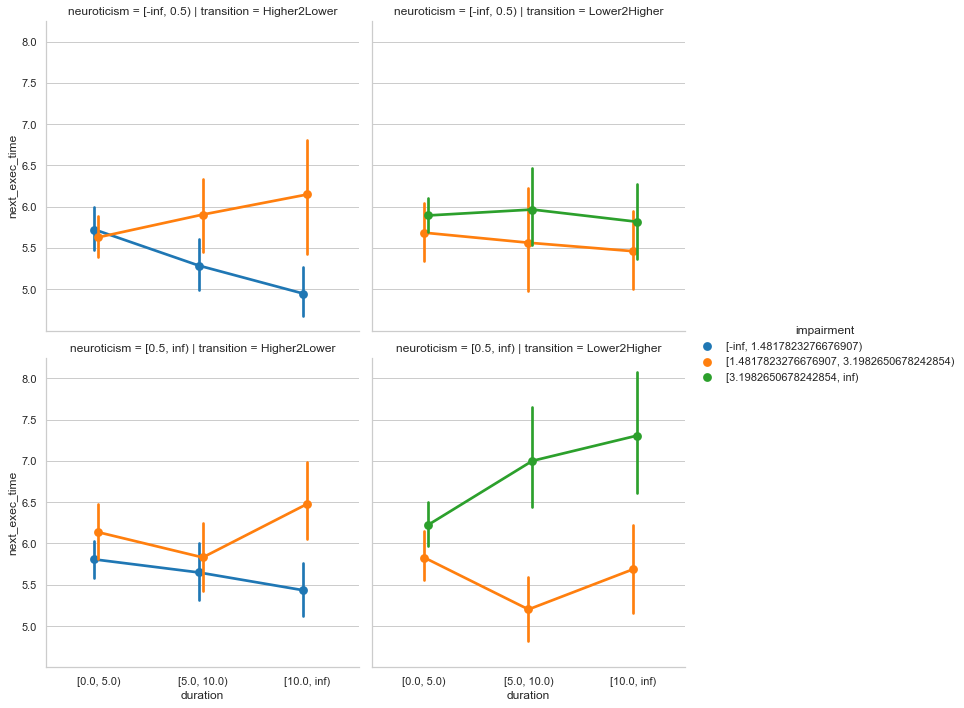

In [97]:
fg = sns.catplot(
    kind="point",
    data=proc_data,
    x="duration",
    hue="impairment",
    y="next_exec_time",
    dodge=True,
    col="transition",
    row="neuroticism",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

plt.show()

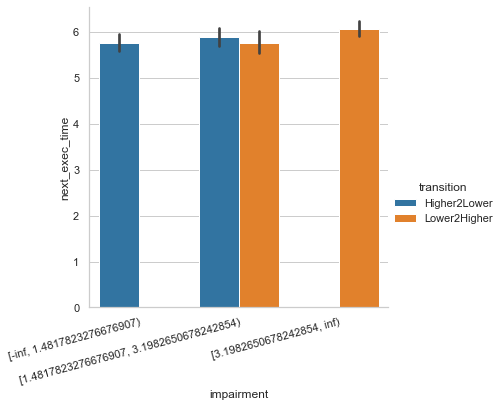

In [28]:
fg = sns.catplot(
    kind="bar",
    data=proc_data[proc_data.duration == proc_data.duration.min()],
    y="next_exec_time",
    x="impairment",
    hue="transition"
)
for ax in fg.axes.flat:
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

plt.show()